## Import all library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import mne
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pywt
from PIL import Image
from utility import *
from model import *
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler


# total_sample = 3628
# num_spike    = 903
# ((total_sample-num_spike)*2)/(num_spike*2) = 3.032
LOSS_POS_WEIGHT       = torch.tensor([3.032])
LEARNING_RATE         = 0.0001
MODEL_FILE_DIRC_WaveGrad = MODEL_FILE_DIRC + "/WaveGrad"
MODEL_FILE_DIRC_DC       = MODEL_FILE_DIRC + "/DC"

torch.manual_seed(3407)

## Data Preparation
* Convert the data from csv to Dataloader

In [2]:
%%time
dataloaders, num_data = get_dataloader(list(range(1,21)), shuffle=True)

num_train_data, num_valid_data, num_test_data = num_data
train_data, valid_data, test_data             = dataloaders

The data from EEG_csv/eeg1.csv is loaded 
There is spike in this eeg file
Data before split : (3840, 19)
Data with   spike: (3840, 19)
Data after  split into window: (3, 1280, 19)
Labels: (3,)
Num spike: 3
EEG1 has 3 windows of data 


The data from EEG_csv/eeg2.csv is loaded 
There is no spike in this eeg file
(160, 1280, 19)
EEG2 has 160 windows of data 


The data from EEG_csv/eeg3.csv is loaded 
There is no spike in this eeg file
(153, 1280, 19)
EEG3 has 153 windows of data 


The data from EEG_csv/eeg4.csv is loaded 
There is no spike in this eeg file
(170, 1280, 19)
EEG4 has 170 windows of data 


The data from EEG_csv/eeg5.csv is loaded 
There is no spike in this eeg file
(148, 1280, 19)
EEG5 has 148 windows of data 


The data from EEG_csv/eeg6.csv is loaded 
There is no spike in this eeg file
(207, 1280, 19)
EEG6 has 207 windows of data 


The data from EEG_csv/eeg7.csv is loaded 
There is no spike in this eeg file
(147, 1280, 19)
EEG7 has 147 windows of data 


The data from 

## Build and Train the Diffusion Classifier model

In [3]:
def load_classification_model_dict(model, MODEL_FILE_DIRC, model_name):
    list_model = os.listdir(MODEL_FILE_DIRC) 
    if len(list_model) > 0:    # Load the latest trained model
        if os.path.exists(f"{MODEL_FILE_DIRC}/{model_name}_best.pt"):
            state_dict_loaded        = torch.load(f"{MODEL_FILE_DIRC}/{model_name}_best.pt")
            prev_best_valid_f1_score = state_dict_loaded["valid_f1_score"]
            prev_best_valid_loss     = state_dict_loaded["valid_loss"]
        list_model.remove(f"{model_name}_best.pt")
        num_list   = [int(model_dir[model_dir.rindex("_") +1: model_dir.rindex(".")]) for model_dir in list_model if model_dir.endswith(".pt")]
        num_max    = np.max(num_list)
        
        state_dict_loaded = torch.load(f"{MODEL_FILE_DIRC}/{model_name}_{num_max}.pt")
        model.load_state_dict(state_dict_loaded["model"])
        EPOCH_START = state_dict_loaded["epoch"] + 1
        
        print(f"The model has been loaded from the file '{model_name}_{num_max}.pt'")

        if os.path.exists(f"{MODEL_FILE_DIRC}/Loss.csv"):
            df = pd.read_csv(f"{MODEL_FILE_DIRC}/Loss.csv")
            df = df.iloc[:EPOCH_START-1, :]
            print(f"The dataframe that record the loss have been loaded from {MODEL_FILE_DIRC}/Loss.csv")

    else:
        EPOCH_START            = 1
        prev_best_valid_f1_score = -1
        prev_best_valid_loss   = 10000
        df                     = pd.DataFrame(columns = ["Train Loss", "Valid Loss"] + \
                                                         flatten_concatenation([[f"Train {metric}", f"Valid {metric}"] for metric in ["precision", "accuracy", "f1_score", "recall"]]) )
    return model, df, EPOCH_START, prev_best_valid_f1_score, prev_best_valid_loss

In [4]:
def start_classification_model_training(EPOCH_START, NUM_EPOCHS_CLASSIFIER, 
                                        model, MODEL_FILE_DIRC, model_name,  
                                        df, prev_best_valid_f1,prev_best_valid_loss,
                                        train_data, num_train_data, 
                                        valid_data, num_valid_data, 
                                        scheduler, optimizer, device):
    count = 0
    for epoch in range(EPOCH_START, NUM_EPOCHS_CLASSIFIER):
        
            ## 1. Training
            model.train()
            train_loss, train_metric = train_diffusion_classifier(model, train_data, device, num_train_data, optimizer, LOSS_POS_WEIGHT=LOSS_POS_WEIGHT) 
            
            ## 2. Evaluating
            model.eval()
            valid_loss, valid_metric = evaluate_diffusion_classifier(model, valid_data, device, num_valid_data, LOSS_POS_WEIGHT=LOSS_POS_WEIGHT) 
            
            ## 3. Show the result
            list_data       = [train_loss, valid_loss]
            for key in ["precision", "accuracy", "f1_score", "recall"]:
                list_data.append(train_metric[key])
                list_data.append(valid_metric[key])
            df.loc[len(df)] = list_data
            
            print_log(f"> > > Epoch     : {epoch}", MODEL_FILE_DIRC)
            if epoch > 5 and (np.isnan(train_loss) or np.isnan(valid_loss)):
                print("Training break as either train loss or valid loss contain nan")
                break
            print_log(f"Train {'loss':<10}: {train_loss}", MODEL_FILE_DIRC)
            print_log(f"Valid {'loss':<10}: {valid_loss}", MODEL_FILE_DIRC)
            for key in ["precision", "accuracy", "f1_score", "recall"]:
                print_log(f"Train {key:<10}: {train_metric[key]}", MODEL_FILE_DIRC)
                print_log(f"Valid {key:<10}: {valid_metric[key]}", MODEL_FILE_DIRC)

            
            ## 3.1 Plot the loss function
            fig,ax = plt.subplots(3,2, figsize=(10,10))
            x_data = range(len(df["Train Loss"]))
            for i, key in enumerate(["Loss","precision", "accuracy", "f1_score", "recall"]):    
                ax[i%3][i//3].plot(x_data, df[f"Train {key}"], label=f"Train {key}")
                ax[i%3][i//3].plot(x_data, df[f"Valid {key}"], label=f"Valid {key}")
                ax[i%3][i//3].legend()
            plt.savefig(f'{MODEL_FILE_DIRC}/Loss.png', transparent=False, facecolor='white')
            plt.close('all')

            ## 3.3. Save model and Stoping criteria
            if prev_best_valid_f1 <= valid_metric["f1_score"]:  # If previous best validation f1-score <= current f1-score 
                state_dict = {
                    "model": model.state_dict(), 
                    "epoch":epoch,
                    "valid_f1_score": valid_metric["f1_score"],
                    "valid_loss": valid_loss
                }
                torch.save(state_dict, f"{MODEL_FILE_DIRC}/{model_name}_best.pt")
                prev_best_valid_f1 = valid_metric["f1_score"]  # Previous validation loss = Current validation loss
                count = 0
            else:
                count += 1
            
            if epoch % 5 == 0:
                state_dict = {
                    "model": model.state_dict(), 
                    "epoch":epoch,
                    "valid_f1_score": valid_metric["f1_score"],
                    "valid_loss": valid_loss
                }
                torch.save(state_dict, f"{MODEL_FILE_DIRC}/{model_name}_{epoch}.pt")
            
            df.to_csv(f"{MODEL_FILE_DIRC}/Loss.csv", index=False)
            
            if count == MAX_COUNT_F1_SCORE:
                print_log(f"The validation f1 score is not increasing for continuous {MAX_COUNT_F1_SCORE} time, so training stop", MODEL_FILE_DIRC)
                break
            
            scheduler.step()


### Start training

In [5]:
# Load the pretrained diffusion model
diffusion_model = WaveGradNN(config).to(device)
if os.path.exists(f"{MODEL_FILE_DIRC_WaveGrad}/Advanced_Diffusion_best.pt"):
    state_dict_loaded    = torch.load(f"{MODEL_FILE_DIRC_WaveGrad}/Advanced_Diffusion_best.pt")
    diffusion_model.load_state_dict(state_dict_loaded["model"])
else:
    raise("No pretrained diffusion model exists")


# Features gotten when b = [1,2,3,4,5] are
# 512 * 16, 256 * 80, 128 * 320, 128 * 1280, 19  * 1280
# Num of trainable parameters: 1,869,185  1,537,089  1,770,881  2,348,865  1,545,153
for b_ in [1,2,3,4,5]:
    for t_ in [5, 10, 20, 50]:
        print(f"> > Training diffusion classifier model when b = {b_} t = {t_}")
        
        MODEL_FILE_DIRC_DC_bt = MODEL_FILE_DIRC_DC + f"_b{b_}_t{t_}"
        os.makedirs(MODEL_FILE_DIRC_DC_bt, exist_ok=True)
        
        # Create Diffusion Classifier and freeze the layer in diffusion model
        model = DiffusionClassifier(config, diffusion_model, device, t_, b_).to(device)
        for param in model.diffusion_model.parameters():
            param.requires_grad = False

        
        optimizer  = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)      
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


        # Get the following information:
        # 1. Previous Trained model (if exist)
        # 2. df that store the training/validation loss & metrics
        # 3. epoch where the training start
        # 4. Previous Highest Validation Recall
        # 5. Previous Lowest  Validation Loss
        info_ = load_classification_model_dict(model, MODEL_FILE_DIRC_DC_bt, "DC")
        model = info_[0]
        df    = info_[1] 
        EPOCH_START = info_[2] 
        prev_best_valid_f1_score = info_[3] 
        prev_best_valid_loss     = info_[4]

        # Print out model info
        seperate = "\n" + "-" * 100 + "\n"
        model_parameters = filter(lambda p: p.requires_grad, model.parameters())
        trainable_params = sum([p.numel() for p in model_parameters])
        print(seperate + "Model infomation" + seperate)
        print(f"Device used       :", device)
        print(f"BATCH SIZE        :", BATCH_SIZE)
        print(f"MAX_COUNT_F1_SCORE:", MAX_COUNT_F1_SCORE)
        print(f"LEARNING RATE     :", LEARNING_RATE)
        print(f"Prev Best recall in validation dataset:", prev_best_valid_f1_score)
        print(f"Prev Best validation loss             :", prev_best_valid_loss)
        print(f"Number of EPOCH for training   :",NUM_EPOCHS_CLASSIFIER, f"(EPOCH start from {EPOCH_START})")
        print(f"Num of epochs of data for train:", num_train_data)
        print(f"Num of epochs of data for valid:", num_valid_data)
        print(f'Model parameters               : {sum(p.numel() for p in model.parameters()):,}' )
        print(f'Trainable Model parameters     : {trainable_params:,}' )
        
        
        # Start training loop
        print(seperate + "Training Log" + seperate)
        start_classification_model_training(EPOCH_START, NUM_EPOCHS_CLASSIFIER, 
                                            model, MODEL_FILE_DIRC_DC_bt, "DC",
                                            df, prev_best_valid_f1_score, prev_best_valid_loss, 
                                            train_data, num_train_data, 
                                            valid_data, num_valid_data, 
                                            scheduler, optimizer, device)
        
        
        # Load the best model and turn to evaluation mode
        model.eval()
        state_dict_loaded = torch.load(f"{MODEL_FILE_DIRC_DC_bt}/DC_best.pt")
        model.load_state_dict(state_dict_loaded["model"])

        test_loss, test_metric = evaluate_diffusion_classifier(model, test_data, device, num_test_data) 

        print("Metric on testing dataset:")
        for key, value in test_metric.items():
            print(f"{key:<10}: {value:.4f}")
        print()

> > Training diffusion classifier model when b = 5 t = 5

----------------------------------------------------------------------------------------------------
Model infomation
----------------------------------------------------------------------------------------------------

Device used       : cuda
BATCH SIZE        : 32
MAX_COUNT_F1_SCORE: 10
LEARNING RATE     : 0.0001
Prev Best recall in validation dataset: -1
Prev Best validation loss             : 10000
Number of EPOCH for training   : 101 (EPOCH start from 1)
Num of epochs of data for train: 2542
Num of epochs of data for valid: 543
Model parameters               : 35,888,052
Trainable Model parameters     : 1,545,153

----------------------------------------------------------------------------------------------------
Training Log
----------------------------------------------------------------------------------------------------

> > > Epoch     : 1
Train loss      : 0.059492244390312095
Valid loss      : 0.050969814068704676


### Result Summary

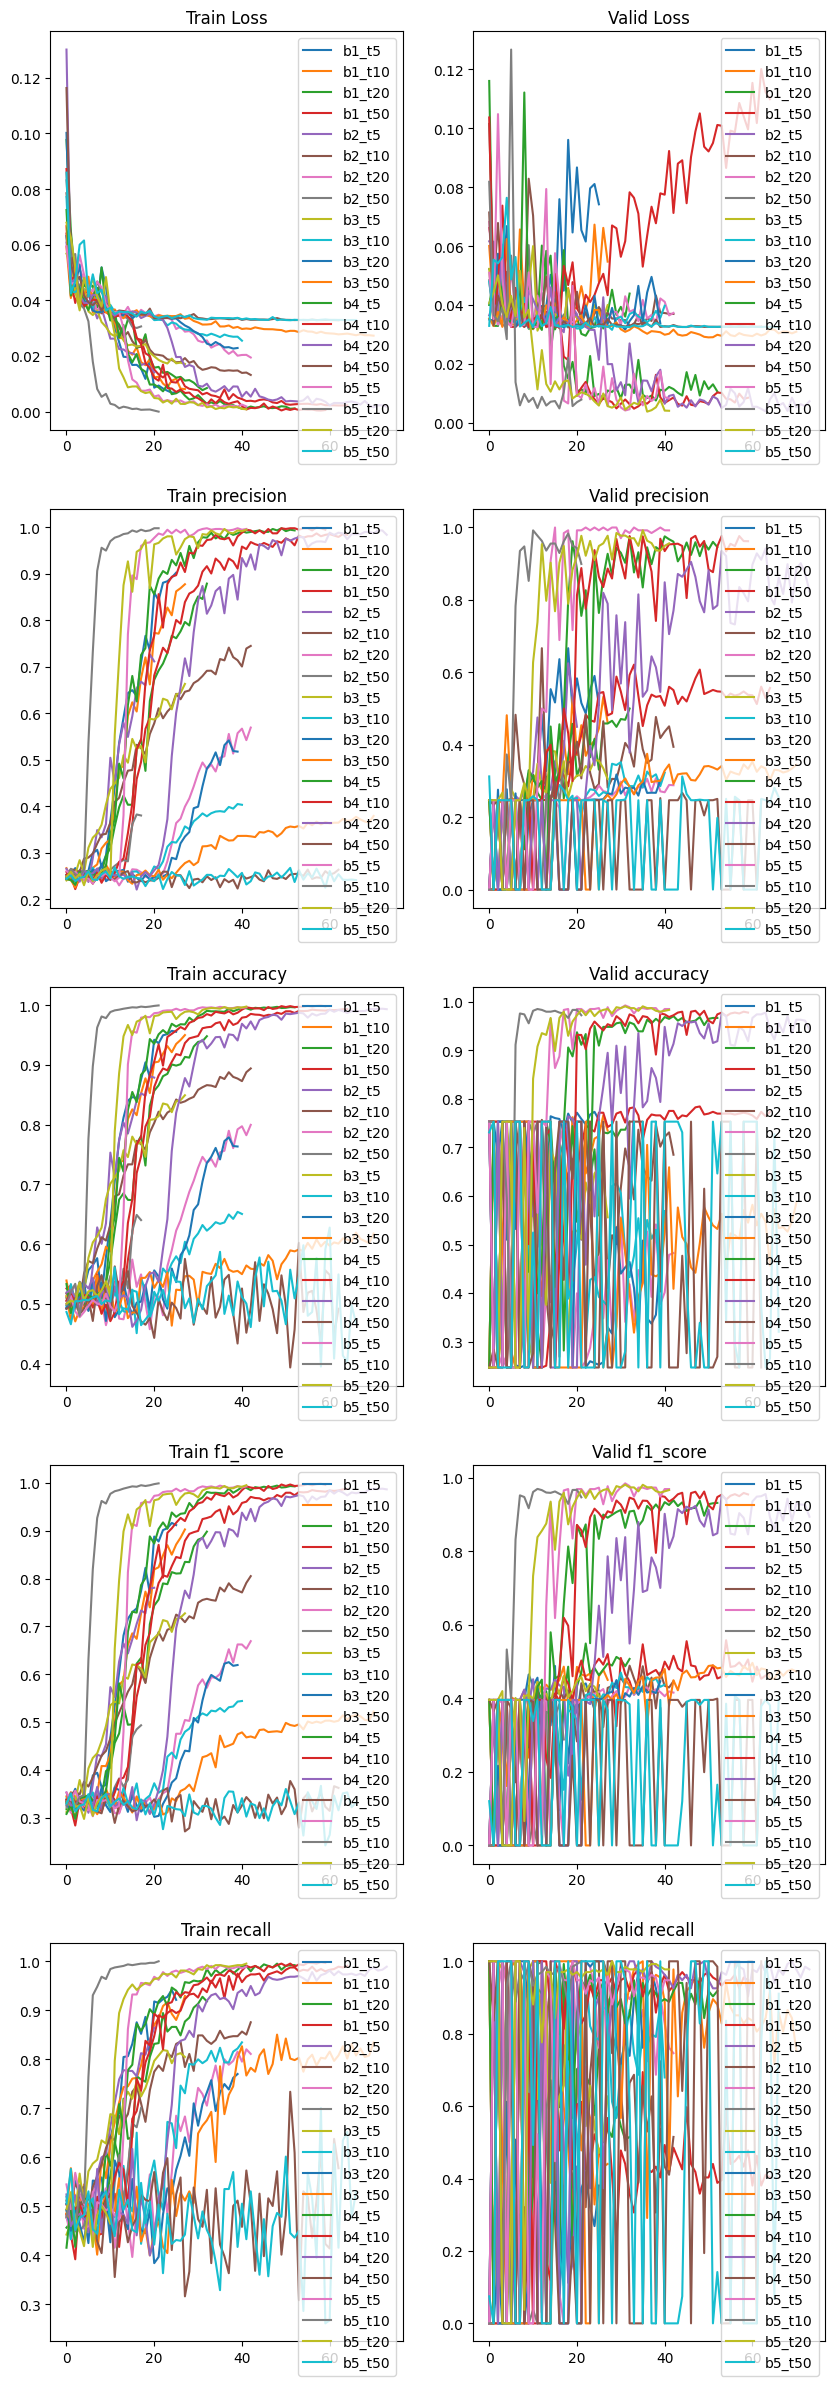

In [6]:
fig, axs   = plt.subplots(5, 2, figsize=(10,30))
DATA_PRONE = 0

for b_ in [1,2,3,4,5]:
    for t_ in [5, 10, 20, 50]:
    # for t_ in [50]:
        MODEL_FILE_DIRC_DC_bt = MODEL_FILE_DIRC_DC + f"_b{b_}_t{t_}"
        df_loss               = pd.read_csv(f"{MODEL_FILE_DIRC_DC_bt}/Loss.csv")
        df_loss               = df_loss.iloc[DATA_PRONE:, :]
        
        for i, col in enumerate(["Loss","precision", "accuracy", "f1_score", "recall"]):
            axs[i][0].plot(range(len(df_loss[f"Train {col}"])), df_loss[f"Train {col}"], label=f"b{b_}_t{t_}")
            axs[i][1].plot(range(len(df_loss[f"Valid {col}"])), df_loss[f"Valid {col}"], label=f"b{b_}_t{t_}")
            
            axs[i][0].set_title(f"Train {col}")
            axs[i][1].set_title(f"Valid {col}")
            
            axs[i][0].legend()
            axs[i][1].legend()

In [33]:
df_summary = []
index_list = []
criteria   = "Valid f1_score"

for b_ in [1,2,3,4,5]:
    for t_ in [5, 10, 20, 50]:
    # for t_ in [10]:
        MODEL_FILE_DIRC_DC_bt = MODEL_FILE_DIRC_DC + f"_b{b_}_t{t_}"
        df_loss               = pd.read_csv(f"{MODEL_FILE_DIRC_DC_bt}/Loss.csv")
        df_loss               = df_loss.iloc[:,2:]
        
        index_list.append(f"b{b_}_t{t_}")

        df_summary.append([b_, t_] + df_loss.iloc[np.argmax(df_loss[criteria]),:].tolist())
        # df_summary.append(df_loss.max().tolist())
        
df_col = df_loss.columns.tolist()
df_col = ["b", "t"] + df_col
df_summary = pd.DataFrame(df_summary, columns=df_col, index=index_list)

## Get performance on testing dataset

In [10]:
# Load the pretrained diffusion model
diffusion_model = WaveGradNN(config).to(device)
if os.path.exists(f"{MODEL_FILE_DIRC_WaveGrad}/Advanced_Diffusion_best.pt"):
    state_dict_loaded    = torch.load(f"{MODEL_FILE_DIRC_WaveGrad}/Advanced_Diffusion_best.pt")
    diffusion_model.load_state_dict(state_dict_loaded["model"])
else:
    raise("No pretrained diffusion model exists")


list_test_metric = []
for b_ in [1,2,3,4,5]:
    for t_ in [5, 10, 20, 50]:
        print(f"Evaluating b={b_}, t={t_}")
        
        MODEL_FILE_DIRC_DC_bt = MODEL_FILE_DIRC_DC + f"_b{b_}_t{t_}"
        
        # Create Diffusion Classifier and freeze the layer in diffusion model
        model = DiffusionClassifier(config, diffusion_model, device, t_, b_).to(device)
        for param in model.diffusion_model.parameters():
            param.requires_grad = False
            
        # Load the best model and turn to evaluation mode
        model.eval()
        state_dict_loaded = torch.load(f"{MODEL_FILE_DIRC_DC_bt}/DC_best.pt")
        model.load_state_dict(state_dict_loaded["model"])

        # Evaluate the best model on the test dataset
        test_loss, test_metric = evaluate_diffusion_classifier(model, test_data, device, num_test_data) 
        
        list_test_metric.append(list(test_metric.values()))

In [34]:
test_metrics = np.array(list_test_metric)

for col, metric in enumerate(test_metric.keys()):
    idx = 4 + col*3
    df_summary.insert(idx, f"Test {metric}", test_metrics[:,col])
    
    print(f"Iteration {col}, Inserting Test {metric:<12} in idx {idx}")

Iteration 0, Inserting Test precision    in idx 4
Iteration 1, Inserting Test accuracy     in idx 7
Iteration 2, Inserting Test f1_score     in idx 10
Iteration 3, Inserting Test recall       in idx 13


In [35]:
df_summary.to_csv("Diffusion_Classifier.csv", index=False)
df_summary

,b,t,Train precision,Valid precision,Test precision,Train accuracy,Valid accuracy,Test accuracy,Train f1_score,Valid f1_score,Test f1_score,Train recall,Valid recall,Test recall
b1_t5,1,5,0.650246,0.516667,0.390977,0.846184,0.760589,0.699816,0.729786,0.488189,0.389513,0.831496,0.462687,0.388060
b1_t10,1,10,0.675676,0.410256,0.339056,0.852478,0.688766,0.615101,0.727273,0.486322,0.430518,0.787402,0.597015,0.589552
b1_t20,1,20,0.707347,0.457711,0.408602,0.881196,0.721915,0.690608,0.789986,0.549254,0.475000,0.894488,0.686567,0.567164
b1_t50,1,50,0.978056,0.530201,0.500000,0.990165,0.769797,0.753223,0.980361,0.558304,0.541096,0.982677,0.589552,0.589552
b2_t5,2,5,0.504796,0.325658,0.300000,0.753344,0.558011,0.539595,0.573179,0.452055,0.410377,0.662992,0.738806,0.649254
b2_t10,2,10,0.691808,0.386957,0.331797,0.866247,0.657459,0.618785,0.757835,0.489011,0.410256,0.837795,0.664179,0.537313
b2_t20,2,20,0.480687,0.284360,0.258850,0.736035,0.418048,0.351750,0.571793,0.431655,0.399317,0.705512,0.895522,0.873134
b2_t50,2,50,0.249593,0.246777,0.246777,0.507868,0.246777,0.246777,0.329223,0.395864,0.395864,0.483465,1.000000,1.000000
b3_t5,3,5,0.529954,0.354839,0.302789,0.770653,0.620626,0.570902,0.612109,0.460733,0.394805,0.724409,0.656716,0.567164
b3_t10,3,10,0.375740,0.351852,0.284884,0.618017,0.605893,0.480663,0.511324,0.470297,0.410042,0.800000,0.708955,0.731343


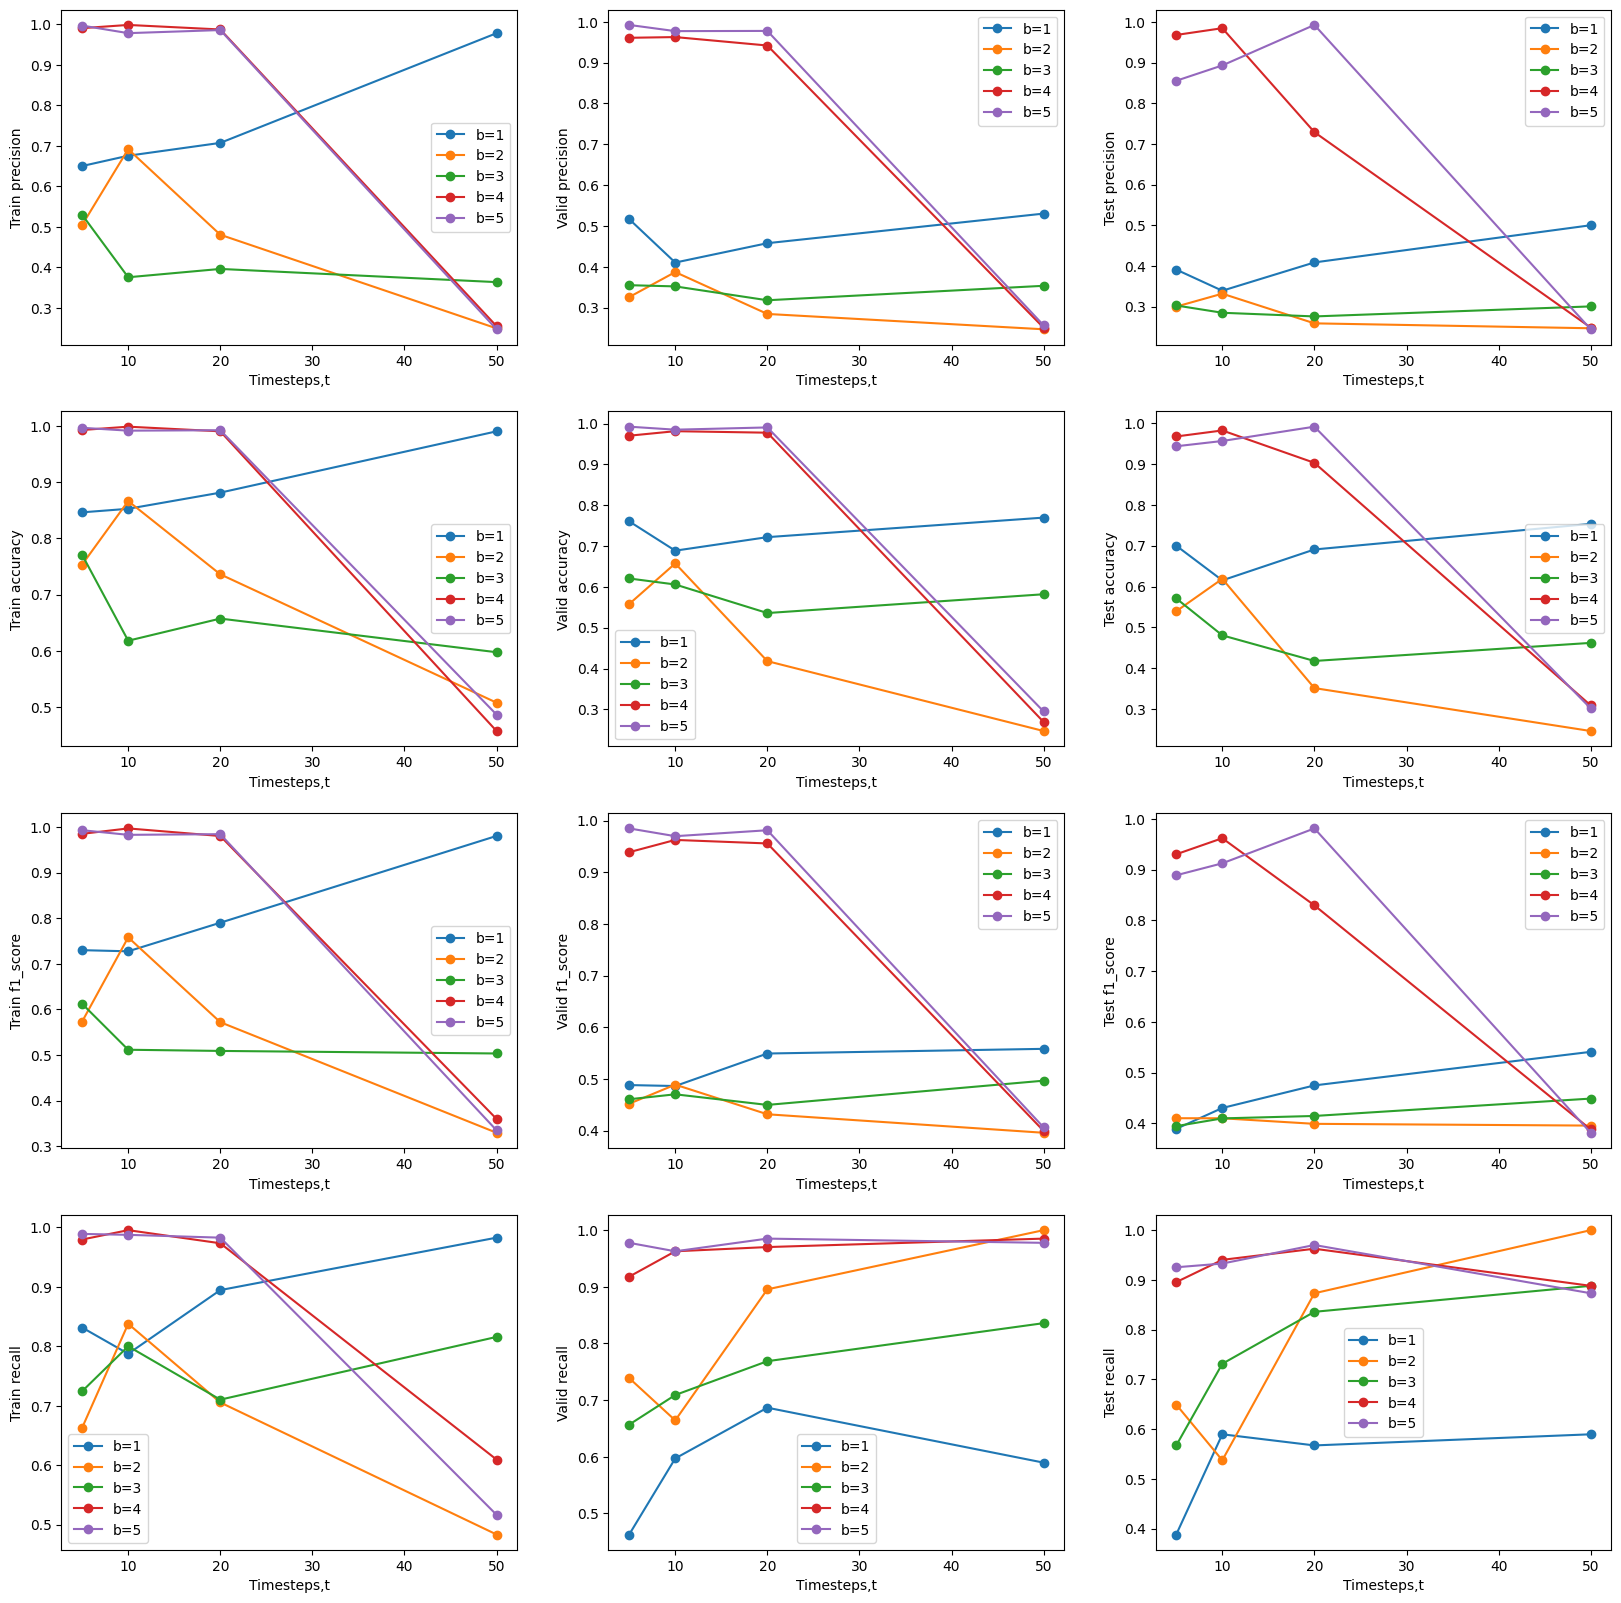

In [46]:
df_summary = pd.read_csv("Diffusion_Classifier.csv")
t_list     = [5,10,20,50]
b_list     = [1,2,3,4,5]

fig, ax = plt.subplots(4,3,figsize=(20,20))

for col, data in enumerate(["Train", "Valid", "Test"]):
    for row, metric in enumerate(["precision", "accuracy", "f1_score", "recall"]):
        y_label = f"{data} {metric}"

        for b_ in b_list:
            ax[row, col].plot(t_list,df_summary[y_label].iloc[(b_-1)*4:b_*4],"o-",label=f"b={b_}")
        ax[row, col].set_ylabel(y_label)
        ax[row, col].set_xlabel("Timesteps,t")
        ax[row, col].legend()

* In brief, 
    * when b=5, t=20 obtain the best result
    * when b= 4, t=10 obtain the best result